In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score


In [69]:
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import learning_curve

In [73]:
df = pd.read_csv("houses_Madrid.csv")
#df = df.set_index(['id'])

In [74]:
df = df.drop('Unnamed: 0',axis=1)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21742 non-null  int64  
 1   title                         21742 non-null  object 
 2   subtitle                      21742 non-null  object 
 3   sq_mt_built                   21616 non-null  float64
 4   sq_mt_useful                  8228 non-null   float64
 5   n_rooms                       21742 non-null  int64  
 6   n_bathrooms                   21726 non-null  float64
 7   n_floors                      1437 non-null   float64
 8   sq_mt_allotment               1432 non-null   float64
 9   latitude                      0 non-null      float64
 10  longitude                     0 non-null      float64
 11  raw_address                   16277 non-null  object 
 12  is_exact_address_hidden       21742 non-null  bool   
 13  s

## Analyse exploratoire

In [76]:
df.describe()

,id,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,latitude,longitude,portal,...,rent_price_by_area,buy_price,buy_price_by_area,built_year,are_pets_allowed,is_furnished,is_kitchen_equipped,has_private_parking,has_public_parking,parking_price
count,21742.000000,21616.000000,8228.000000,21742.000000,21726.000000,1437.000000,1432.000000,0.0,0.0,0.0,...,0.0,2.174200e+04,21742.000000,10000.000000,0.0,0.0,0.0,0.0,0.0,7719.000000
mean,10871.500000,146.920892,103.458192,3.005749,2.091687,3.128740,241.692737,NaN,NaN,NaN,...,NaN,6.537356e+05,4020.523871,1970.046400,NaN,NaN,NaN,NaN,NaN,2658.000518
std,6276.519112,134.181865,88.259192,1.510497,1.406992,0.907713,247.484853,NaN,NaN,NaN,...,NaN,7.820821e+05,1908.418774,69.386705,NaN,NaN,NaN,NaN,NaN,13360.966258
min,1.000000,13.000000,1.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,...,NaN,3.600000e+04,447.000000,1723.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,5436.250000,70.000000,59.000000,2.000000,1.000000,2.000000,2.000000,NaN,NaN,NaN,...,NaN,1.980000e+05,2551.000000,1957.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,10871.500000,100.000000,79.000000,3.000000,2.000000,3.000000,232.000000,NaN,NaN,NaN,...,NaN,3.750000e+05,3720.000000,1970.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,16306.750000,162.000000,113.000000,4.000000,2.000000,4.000000,354.000000,NaN,NaN,NaN,...,NaN,7.636000e+05,5000.000000,1994.000000,NaN,NaN,NaN,NaN,NaN,0.000000
max,21742.000000,999.000000,998.000000,24.000000,16.000000,7.000000,997.000000,NaN,NaN,NaN,...,NaN,8.800000e+06,18889.000000,8170.000000,NaN,NaN,NaN,NaN,NaN,600000.000000


A première vue, il semble que le jeu de données contient des outliers.  
Il serait pertinent d'utiliser l'écart inter-quartile pour les isoler.

In [67]:
def iqr(col):
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = col[(col < lower_bound) | (col > upper_bound)]
    return outliers.count()

outliers_sum = {}

# Appliquer la fonction à chaque colonne et stocker les sommes des outliers
for column in df.select_dtypes('number').columns:
    outliers_sum[column] = iqr(df[column])

# Afficher les sommes des outliers par colonne
for column, sum_value in outliers_sum.items():
    print(f"La colonne {column} a une somme d'outliers de : {sum_value}")


La colonne m2_construit a une somme d'outliers de : 848
La colonne nb_pieces a une somme d'outliers de : 1067
La colonne nb_sdb a une somme d'outliers de : 641
La colonne nb_etages a une somme d'outliers de : 377
La colonne prix_achat a une somme d'outliers de : 838
La colonne prix_achat_m2 a une somme d'outliers de : 245
La colonne annee_construction a une somme d'outliers de : 1078
La colonne num_quartier a une somme d'outliers de : 0


In [5]:
df.drop(['Unnamed: 0','latitude','longitude','portal','door','are_pets_allowed','is_furnished','is_kitchen_equipped','has_private_parking','has_public_parking','has_central_heating','has_individual_heating','is_exterior'], axis=1, inplace=True)
df.drop(['is_accessible','is_buy_price_known','is_rent_price_known','rent_price_by_area','rent_price','operation','is_floor_under','street_number','street_name','is_exact_address_hidden','raw_address','subtitle','title'], axis=1, inplace=True)
df.drop(['sq_mt_allotment','is_parking_included_in_price','parking_price','sq_mt_useful','is_orientation_north','is_orientation_west','is_orientation_south','is_orientation_east','has_ac','has_fitted_wardrobes','energy_certificate'], axis=1, inplace=True)
df.drop('floor', axis=1, inplace=True)
df.dropna(subset=['sq_mt_built'], how='all', inplace=True)
df.dropna(subset=['n_bathrooms'], how='all', inplace=True) 

In [6]:
df.fillna({'n_floors': 0}, inplace=True)

In [7]:
#df['built_year'] = np.where(df['is_new_development'] == True, 2022, df['built_year'])
df.drop('is_new_development', axis=1, inplace=True)
df["built_year"] = pd.to_numeric(df["built_year"])
#df['built_year'] = np.where(df['built_year'] < 2000, 1, df['built_year'])
#df['built_year'] = np.where(df['built_year'] >= 2000, 0, df['built_year'])

In [8]:
col_liste = ['has_green_zones','has_terrace','has_balcony','has_storage_room','has_garden','has_lift','has_pool']
for col in df[col_liste]:
    df[col] = df[col].fillna('False')

In [9]:
pattern = r'Neighborhood (\d+): ([\w\s]+) \(([\d\.]+) €/m2\) - District (\d+): ([\w\s]+)'
df[['Neighborhood_number', 'nom_quartier', 'euro_m2', 'district_number', 'district']] = df['neighborhood_id'].str.extract(pattern)
df.drop(['neighborhood_id','Neighborhood_number','nom_quartier','euro_m2','district'],axis=1,inplace=True)
df.fillna({'district_number': 16}, inplace=True)

In [10]:
df.dropna(subset=['house_type_id'], how='all', inplace=True)
df.loc[df['house_type_id'].str.contains("ticos"),'house_type_id'] = 'penthouse'
df.loc[df['house_type_id'].str.contains("plex"),'house_type_id'] = 'duplex'
df.loc[df['house_type_id'].str.contains("Casa"),'house_type_id'] = 'maison'
df.loc[df['house_type_id'].str.contains("Pisos"),'house_type_id'] = 'appartement'

In [11]:
col_dict={'sq_mt_built':'m2_construit','n_rooms':'nb_pieces','n_bathrooms':'nb_sdb','n_floors':'nb_etages',
         'buy_price':'prix_achat','buy_price_by_area':'prix_achat_m2','house_type_id':'type_maison',
         'is_renewal_needed':'travaux_necessaire','built_year':'annee_construction','has_lift':'ascenseur','has_garden':'jardin',
         'has_pool':'piscine','has_terrace':'terrace','has_balcony':'balcon','has_storage_room':'salle_rangement',
         'has_green_zones':'espace_vert','has_parking':'parking','district_number':'num_quartier'}
df.rename(columns=col_dict, inplace=True)

In [12]:
df['ascenseur'] = df['ascenseur'].map({'False':False, 'True':True})
df['jardin'] = df['jardin'].map({'False':False, 'True':True})
df['piscine'] = df['piscine'].map({'False':False, 'True':True})
df['terrace'] = df['terrace'].map({'False':False, 'True':True})
df['balcon'] = df['balcon'].map({'False':False, 'True':True})
df['salle_rangement'] = df['salle_rangement'].map({'False':False, 'True':True})
df['espace_vert'] = df['espace_vert'].map({'False':False, 'True':True})

df=df.astype({"m2_construit":int, "nb_sdb":int, 'nb_sdb':int, 'nb_etages':int, 'ascenseur':bool,
          'jardin':bool, 'piscine':bool, 'terrace':bool, 'balcon':bool, 'salle_rangement':bool, 'espace_vert':bool,
          'num_quartier':int})

In [13]:
df = df[df['nb_pieces'] >= 1]
df = df[df['nb_sdb'] <= 6]
df = df[df['prix_achat'] <= 1750000]
df = df[df['prix_achat_m2'] <= 10000]
df = df[df['m2_construit'] <= 300]
df.fillna({'annee_construction': 2077}, inplace=True)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18515 entries, 0 to 21741
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  18515 non-null  int64  
 1   m2_construit        18515 non-null  int64  
 2   nb_pieces           18515 non-null  int64  
 3   nb_sdb              18515 non-null  int64  
 4   nb_etages           18515 non-null  int64  
 5   prix_achat          18515 non-null  int64  
 6   prix_achat_m2       18515 non-null  int64  
 7   type_maison         18515 non-null  object 
 8   travaux_necessaire  18515 non-null  bool   
 9   annee_construction  18515 non-null  float64
 10  ascenseur           18515 non-null  bool   
 11  jardin              18515 non-null  bool   
 12  piscine             18515 non-null  bool   
 13  terrace             18515 non-null  bool   
 14  balcon              18515 non-null  bool   
 15  salle_rangement     18515 non-null  bool   
 16  espace_ve

In [15]:
df = pd.get_dummies(df, prefix=['type'], columns=['type_maison'])#,drop_first=True)
df.drop('id', axis=1, inplace=True)

In [16]:
df.columns

Index(['m2_construit', 'nb_pieces', 'nb_sdb', 'nb_etages', 'prix_achat',
       'prix_achat_m2', 'travaux_necessaire', 'annee_construction',
       'ascenseur', 'jardin', 'piscine', 'terrace', 'balcon',
       'salle_rangement', 'espace_vert', 'parking', 'num_quartier',
       'type_appartement', 'type_duplex', 'type_maison', 'type_penthouse'],
      dtype='object')

In [17]:
df_annee = df[df['annee_construction'] > 1950]
df_annee = df_annee[df_annee['annee_construction'] <= 2024]

data = df_annee.drop('annee_construction', axis=1)
target = df_annee['annee_construction']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)

In [18]:
model_en = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),max_iter=10000)

model_en.fit(X_train, y_train)
print('')

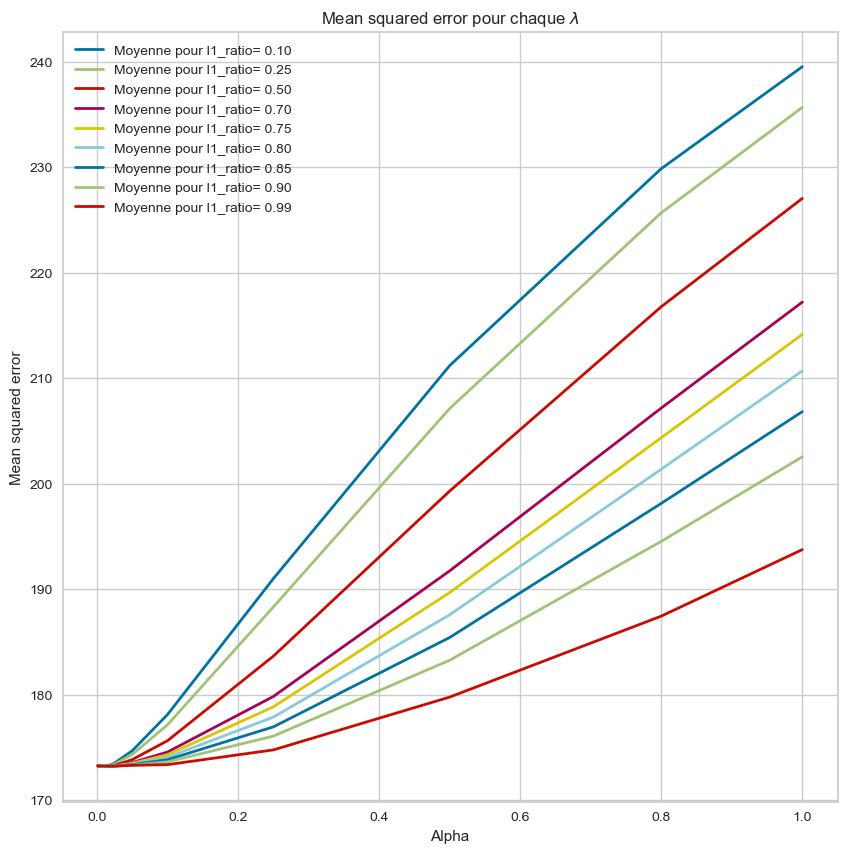

In [19]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

In [20]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

13.096924423789975
13.342825666747089


In [21]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.503382454407304
score test : 0.5112262220871993


In [22]:
pd.DataFrame({'points_observés': y_test, 'points_predits' : np.round(pred_test)}, 
             index=X_test.index).head(7)

,points_observés,points_predits
14739,2019.0,1995.0
11431,1955.0,1972.0
20661,1968.0,1977.0
10181,1972.0,1967.0
8595,1987.0,2004.0
3291,1960.0,1983.0
6291,1965.0,1965.0


In [23]:
model_final = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),max_iter=10000)

model_final.fit(data, target)
print('')

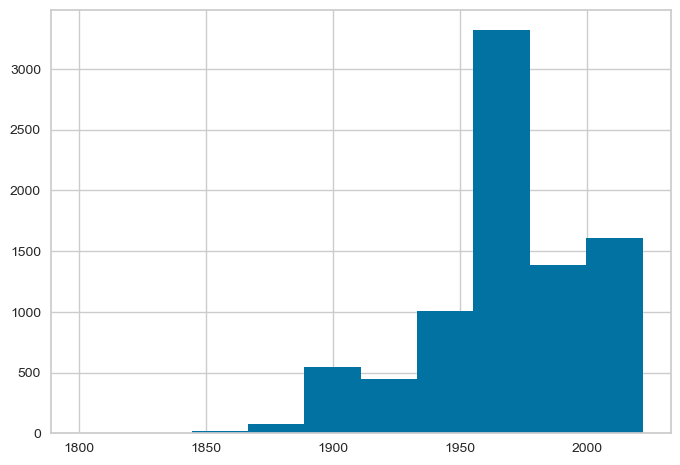

In [24]:
df.loc[df['annee_construction'] <= 2024].annee_construction.hist();

In [25]:
df['predict'] = model_final.predict(df.drop('annee_construction', axis=1))
df=df.astype({"predict":int})
df.loc[df['annee_construction'] >= 2024,'annee_construction'] = df.loc[df['annee_construction'] >= 2024, 'predict']
df=df.drop(['predict'],axis=1)

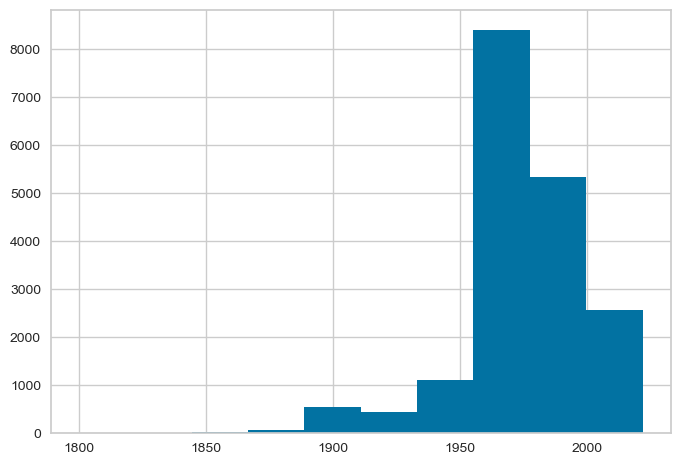

In [26]:
df.annee_construction.hist();

In [27]:
visu = df_annee.copy()

In [28]:
visu['num_quartier'].unique()

array([21, 16, 19, 20, 18, 17, 14, 13, 11, 12, 10,  8,  9,  6,  7,  5,  3,
        4, 15,  1,  2])

In [29]:
# Création du dictionnaire des districts
district_number = [11, 3, 6, 5, 7, 13, 15, 8, 17, 1, 14, 9, 21, 10, 18, 4, 20, 12, 19, 2, 16]
district = ['Moncloa', 'Carabanchel', 'Chamberi', 'Chamartín', 'Ciudad Lineal', 
            'Puente de Vallecas', 'Salamanca', 'Fuencarral', 'Tetuan', 'Arganzuela', 
            'Retiro', 'Hortaleza', 'Villaverde', 'Latina', 'Usera', 'Centro', 
            'Villa de Vallecas', 'Moratalaz', 'Vicalvaro', 'Barajas','Hortaleza']
district_dict = {num: dist for num, dist in zip(district_number, district)}

# Ajout d'une nouvelle colonne avec le nom des districts
visu['district_name'] = visu['num_quartier'].map(district_dict)

# Affichage des premières lignes du DataFrame pour vérification
visu.head()

,m2_construit,nb_pieces,nb_sdb,nb_etages,prix_achat,prix_achat_m2,travaux_necessaire,annee_construction,ascenseur,jardin,...,balcon,salle_rangement,espace_vert,parking,num_quartier,type_appartement,type_duplex,type_maison,type_penthouse,district_name
0,64,2,1,0,85000,1328,False,1960.0,True,False,...,False,False,False,False,21,True,False,False,False,Villaverde
3,64,2,1,0,109900,1717,False,1955.0,True,False,...,False,True,False,False,21,True,False,False,False,Villaverde
4,108,2,2,0,260000,2407,False,2003.0,True,False,...,False,True,True,True,21,True,False,False,False,Villaverde
5,126,4,2,0,195000,1548,False,1981.0,True,False,...,True,False,False,True,21,True,False,False,False,Villaverde
10,69,2,2,0,118000,1710,True,1963.0,True,False,...,False,False,False,False,21,True,False,False,False,Villaverde


In [30]:
visu.to_csv('visuel.csv')

# Tests différents modèles de regression

## ElasticNet version Sarah

## Regression linéaire simple

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


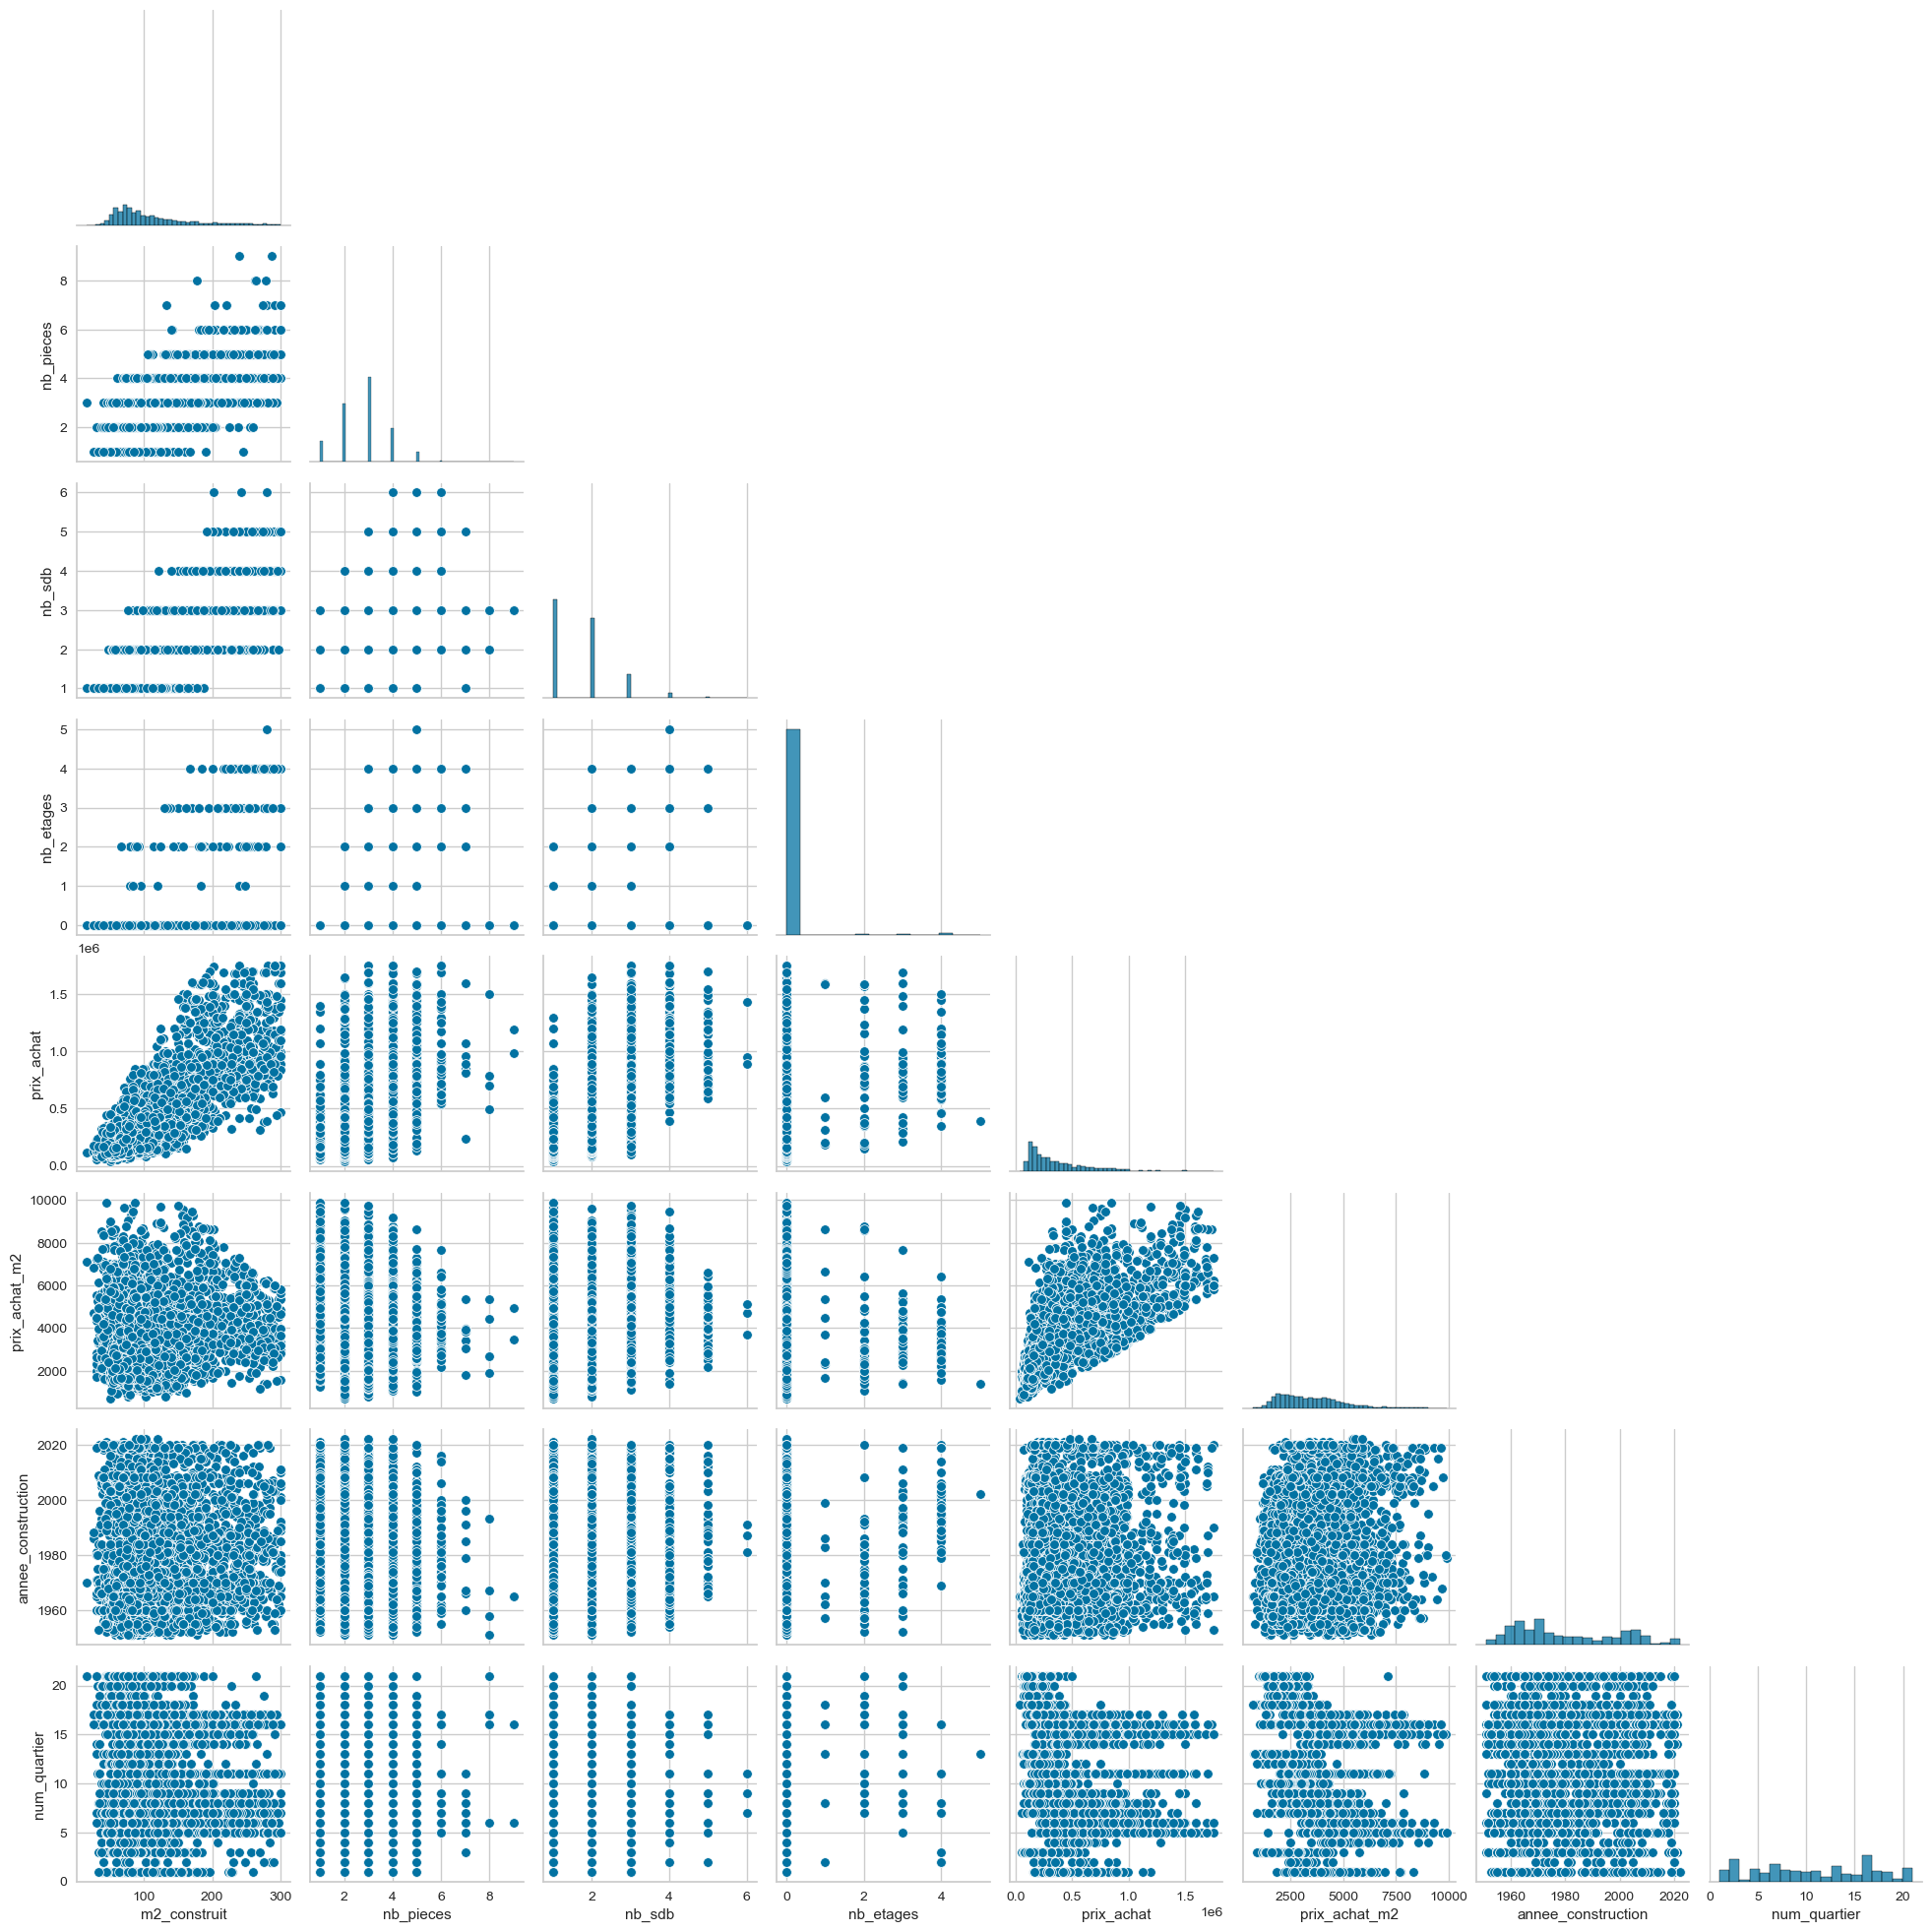

In [31]:
import seaborn as sns
sns.pairplot(data=df_annee.select_dtypes(exclude='bool'),corner=True)

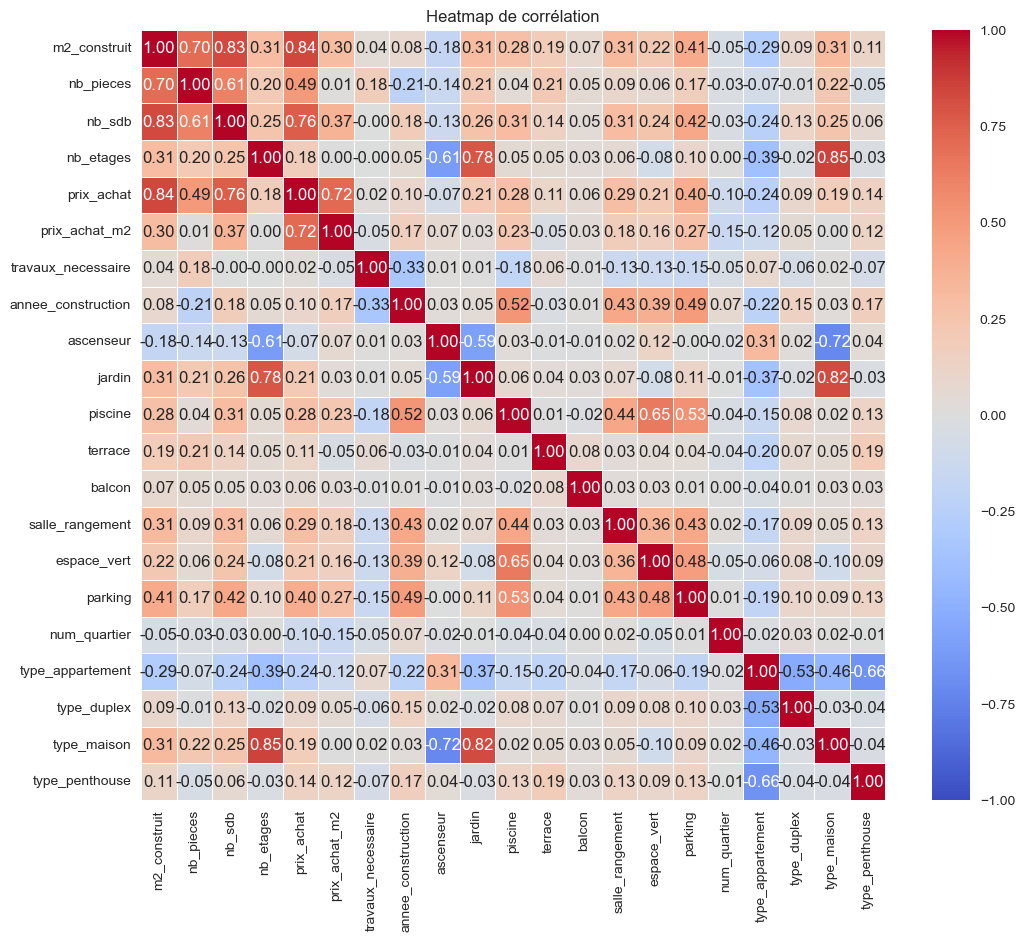

In [32]:
import seaborn as sns

# Calculez la matrice de corrélation
corr_matrix = df_annee.corr()

# Tracez la heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,vmin=-1,vmax=1)
plt.title('Heatmap de corrélation')
plt.show()


Je commence par un modèle de régression linéaire simple que j'utiliserai comme baseline pour comparer les scores avec les autres modèles.  
La matrice de corrélation indique que la variable m2_construit est la variable la plus corrélée à la target 'prix_achat'.

## Régression simple avec la feature 'm2_construit'

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Création de données fictives
X = df_annee['m2_construit'].values.reshape(-1, 1)
y = df_annee['prix_achat']

# Division des données en ensembles d'entraînement et de test
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de l'objet de régression linéaire
regression = LinearRegression()

# Ajustement du modèle aux données d'entraînement
regression.fit(X_train_reg, y_train_reg)

# Prédiction sur les données de test
y_pred_reg = regression.predict(X_test_reg)

# Calcul de l'erreur quadratique moyenne
r2_train = regression.score(X_train_reg, y_train_reg)
r2_predict = regression.score(X_test_reg, y_test_reg)

print('R² train :', r2_train)
print('R² predict:', r2_predict)

# Calcul du Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print("MAE:", mae)

# Calcul du Mean Squared Error (MSE)
mse = mean_squared_error(y_test_reg, y_pred_reg)
print("MSE:", mse)

# Calcul de la racine de l'erreur quadratique moyenne (RMSE)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


R² train : 0.705614542297524
R² predict: 0.7014618634042046
MAE: 117241.63711658357
MSE: 28754788085.56045
RMSE: 169572.36828434182


La regréssion linéaire affiche un score de prédiction de 0.70.  


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


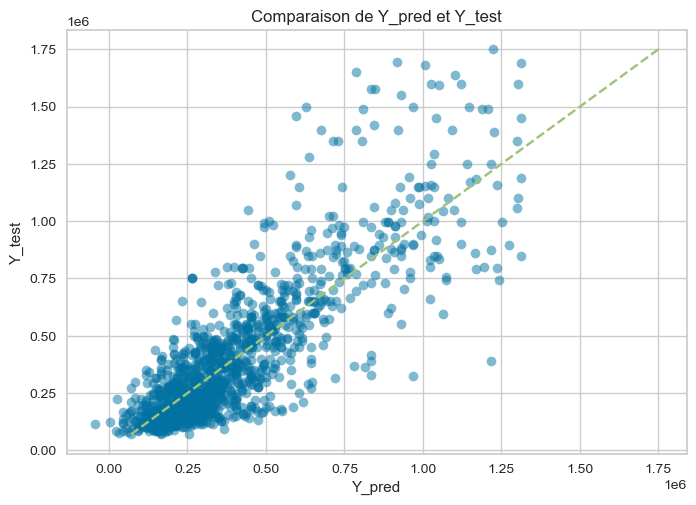

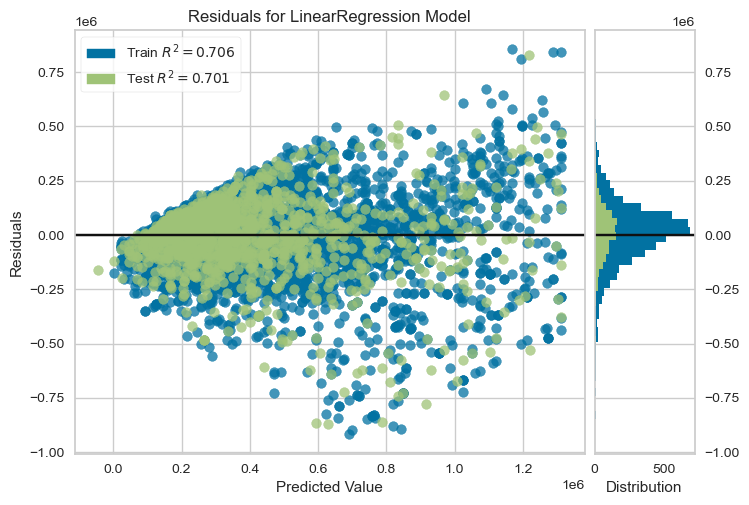

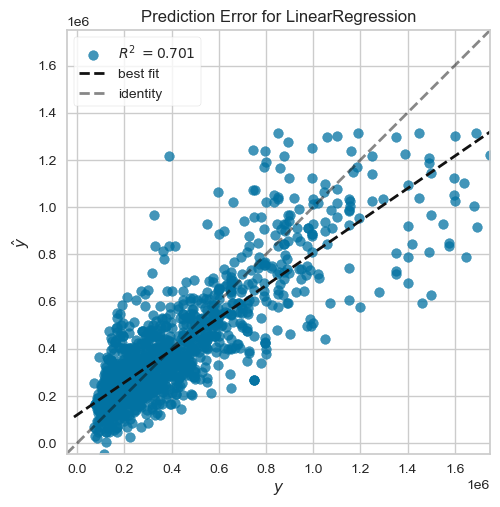

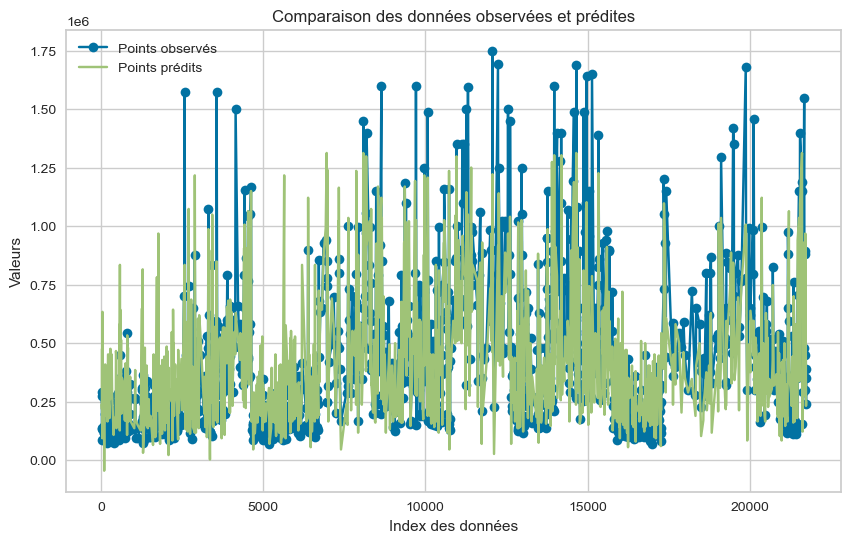

In [34]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Affichage des résultats de la régression polynomiale
plt.plot(y_pred_reg, y_test_reg, 'o', alpha=0.5)
min_true = y_test_reg.min()
max_true = y_test_reg.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend()
plt.show()

# Visualisation des résidus
visualizer = ResidualsPlot(regression)
visualizer.fit(X_train_reg, y_train_reg)  # Adapter les données d'entraînement au visualiseur
visualizer.score(X_test_reg, y_test_reg)  # Évaluer le modèle sur les données de test
visualizer.show()                     # Finaliser et afficher la figure

# Visualisation de l'erreur de prédiction
visualizer = PredictionError(regression)
visualizer.fit(X_train_reg, y_train_reg)
visualizer.score(X_test_reg, y_test_reg)
visualizer.show()


# Créer un DataFrame avec les points observés et les points prédits
donnees_comparatives_reg = pd.DataFrame({'points_observés': y_test_reg, 'points_predits': y_pred_reg})

# Trier les données par index si nécessaire
donnees_comparatives_reg = donnees_comparatives_reg.sort_index()

# Tracer les données observées et prédites
plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_reg.index, donnees_comparatives_reg['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_reg.index, donnees_comparatives_reg['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()



## Modèle ElasticNetCV 

In [35]:
# Données et cible
data = df_annee.drop('prix_achat', axis=1)
target = df_annee['prix_achat']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Modèle ElasticNetCV
model_en = ElasticNetCV(cv=5, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
                        max_iter=10000)

model_en.fit(X_train, y_train)

# Prédictions sur les ensembles d'entraînement et de test
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)

# Calcul des métriques
mae_test = mean_absolute_error(y_test, pred_test)
mse_test = mean_squared_error(y_test, pred_test)
rmse_test = np.sqrt(mse_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print("R2 train:", r2_train)
print("R2 test:", r2_test)
print("MAE:", mae_test)
print("MSE:", mse_test)
print("RMSE:", rmse_test)


R2 train: 0.9453341065733275
R2 test: 0.9478561444948993
MAE: 46736.17946643489
MSE: 5022425382.936397
RMSE: 70869.07211849466


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


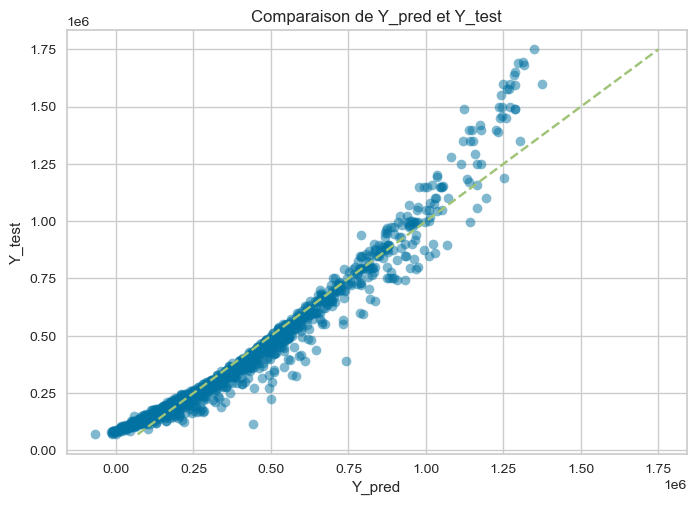

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


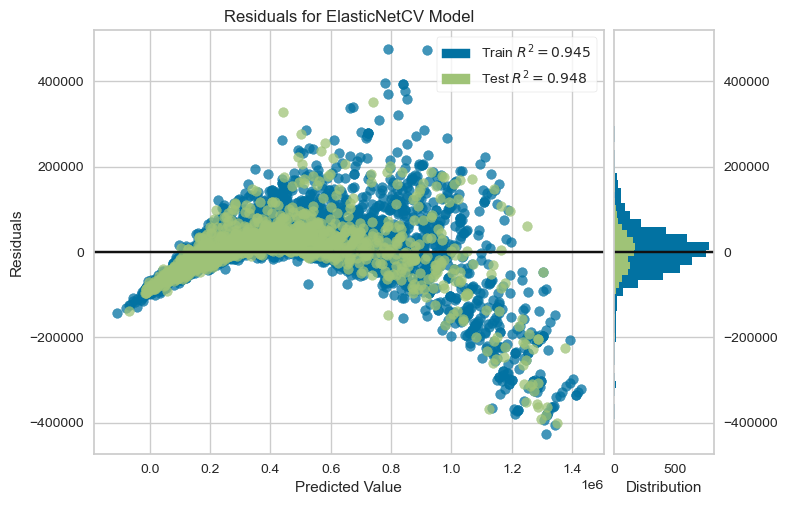

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


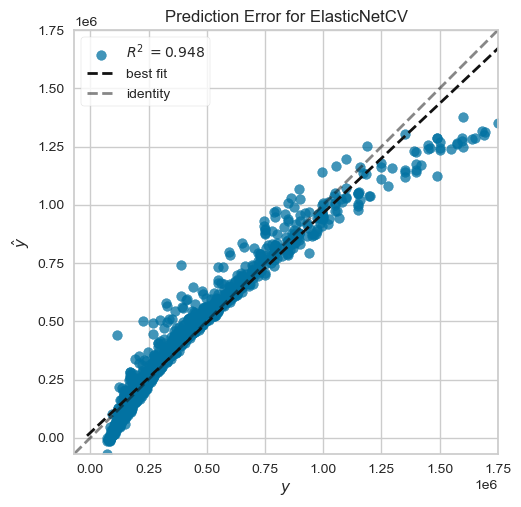

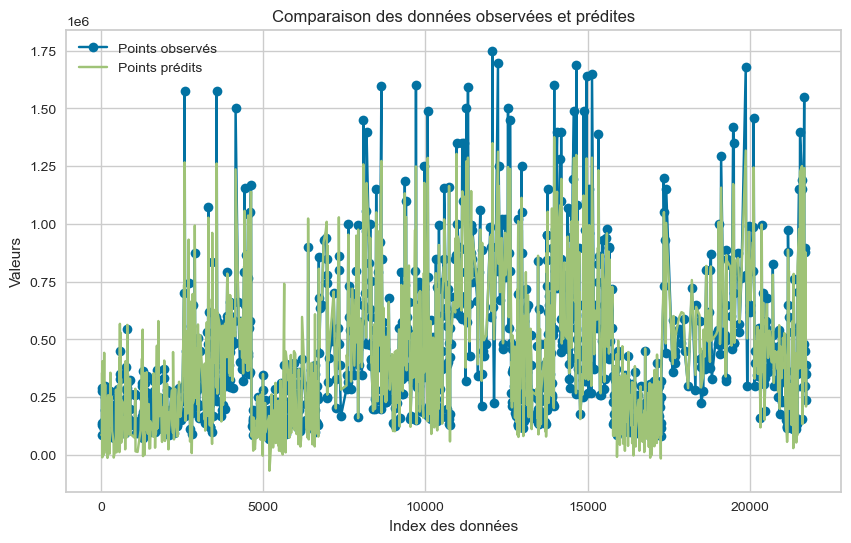

In [36]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Affichage des résultats de la régression polynomiale
plt.plot(pred_test, y_test, 'o', alpha=0.5)
min_true = y_test.min()
max_true = y_test.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend()
plt.show()

# Visualisation des résidus
visualizer = ResidualsPlot(model_en)
visualizer.fit(X_train, y_train)  # Adapter les données d'entraînement au visualiseur
visualizer.score(X_test, y_test)  # Évaluer le modèle sur les données de test
visualizer.show()                     # Finaliser et afficher la figure

# Visualisation de l'erreur de prédiction
visualizer = PredictionError(model_en)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


# Créer un DataFrame avec les points observés et les points prédits
donnees_comparatives_model_en = pd.DataFrame({'points_observés': y_test, 'points_predits': pred_test})

# Trier les données par index si nécessaire
donnees_comparatives_model_en = donnees_comparatives_model_en.sort_index()

# Tracer les données observées et prédites
plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_en.index, donnees_comparatives_model_en['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_en.index, donnees_comparatives_model_en['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()



In [64]:
pd.DataFrame({'points_observés': y_test, 'points_predits' : np.round(pred_test)}, 
             index=X_test.index)

,points_observés,points_predits
5831,154000,115163.0
16614,125000,67784.0
13851,349000,356694.0
20300,470000,481286.0
12846,259000,299406.0
...,...,...
9757,390000,413657.0
12671,360000,404666.0
9198,380000,398621.0
11645,790000,791991.0


Ce deuxième modèle obtient un meilleur score que la régression linéaire simple mais il affiche un RMSE à 70869 ce qui représente une marge d'erreur trop grande pour que le modèle soit efficace.  
Je vais reprendre le modèle mais en vérifiant au préalable si les variables explicatives sont en multicollinéarité avec le calcul du VIF. 

In [38]:
# Liste des noms des colonnes booléennes
colonnes_bool = X_train.select_dtypes(include='bool')

# Boucle sur chaque colonne booléenne et les convertir en entiers
for col in colonnes_bool:
    X_train[col] = X_train[col].astype(int)


In [39]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_columns = ['m2_construit',
 'nb_pieces',
 'nb_sdb',
 'nb_etages',
 'prix_achat_m2',
 'travaux_necessaire',
 'annee_construction',
 'ascenseur',
 'jardin',
 'piscine',
 'terrace',
 'balcon',
 'salle_rangement',
 'espace_vert',
 'parking',
 'num_quartier',
 'type_appartement',
 'type_duplex',
 'type_maison',
 'type_penthouse']

# Calcul du VIF pour les variables numériques
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X_train[numeric_columns].values, i) for i in range(len(numeric_columns))]

print('VIF (facteur d\'inflation de la variance) pour les variables numériques :')
print(vif_data)

VIF (facteur d'inflation de la variance) pour les variables numériques :
               feature           VIF
0         m2_construit      4.670264
1            nb_pieces      2.700150
2               nb_sdb      3.725076
3            nb_etages      3.967127
4        prix_achat_m2      1.377593
5   travaux_necessaire      1.156994
6   annee_construction      1.990172
7            ascenseur      2.107349
8               jardin      3.603261
9              piscine      2.246222
10             terrace      1.129052
11              balcon      1.017832
12     salle_rangement      1.419291
13         espace_vert      1.919855
14             parking      1.888854
15        num_quartier      1.044956
16    type_appartement  19945.363045
17         type_duplex    738.424976
18         type_maison    578.807448
19      type_penthouse   1117.542378


Une valeur supérieure à 10 indique multicolinéarité des variables.  


In [40]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric_columns = ['m2_construit','nb_etages', 'prix_achat_m2', 'travaux_necessaire',
 'jardin', 'piscine','terrace','balcon','salle_rangement','espace_vert','parking','num_quartier',
 'type_duplex', 'type_maison', 'type_penthouse']


vif_data = pd.DataFrame()
vif_data["feature"] = numeric_columns
vif_data["VIF"] = [variance_inflation_factor(X_train[numeric_columns].values, i) for i in range(len(numeric_columns))]

print('VIF (facteur d\'inflation de la variance) pour les variables numériques :')
print(vif_data)

VIF (facteur d'inflation de la variance) pour les variables numériques :
               feature       VIF
0         m2_construit  7.012805
1            nb_etages  4.025871
2        prix_achat_m2  5.147115
3   travaux_necessaire  1.321225
4               jardin  3.658821
5              piscine  2.729730
6              terrace  2.049427
7               balcon  1.171774
8      salle_rangement  2.108614
9          espace_vert  2.602837
10             parking  2.705307
11        num_quartier  2.997246
12         type_duplex  1.066198
13         type_maison  4.654739
14      type_penthouse  1.134976


Les variables explicatives ne sont plus en multicolinéarités, je peux à présent tester à nouveau le modèle ElasticNetCV.

In [41]:
vif_data_list =vif_data.feature.to_list()

In [42]:
Xs = df_annee[vif_data_list]
ys = df_annee['prix_achat']

# Division des données en ensembles d'entraînement, de validation et de test
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(Xs, ys, test_size=0.2)
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_train_s, y_train_s, test_size=0.2)

# Entraînement du modèle ElasticNet avec les données
model_en_s = ElasticNetCV(
    cv=5, 
    l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
    alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
    max_iter=10000
)
model_en_s.fit(X_train_s, y_train_s)

# Validation croisée
cv_scores = cross_val_score(model_en_s, X_train_s, y_train_s, cv=3, verbose=2)

# Prédiction sur les données d'entraînement, de validation et de test
pred_train_s = model_en_s.predict(X_train_s)
pred_val_s = model_en_s.predict(X_val_s)
pred_test_s = model_en_s.predict(X_test_s)

# Calcul de l'erreur quadratique moyenne
r2_train = model_en_s.score(X_train_s, y_train_s)
r2_predict = model_en_s.score(X_test_s, y_test_s)
MAE = mean_absolute_error(y_test_s, pred_test_s)
MSE = mean_squared_error(y_test_s, pred_test_s)
RMSE = np.sqrt(mean_squared_error(y_test_s, pred_test_s))

print('R² train :', r2_train)
print('R² predict:', r2_predict)
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('Validation croisée scores :', cv_scores)


[CV] END .................................................... total time=   0.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s
R² train : 0.945526185059087
R² predict: 0.9449363823113013
MAE : 48673.80402600663
MSE : 5408524427.894351
RMSE : 73542.67079658143
Validation croisée scores : [0.94581878 0.94145795 0.94518676]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s finished


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


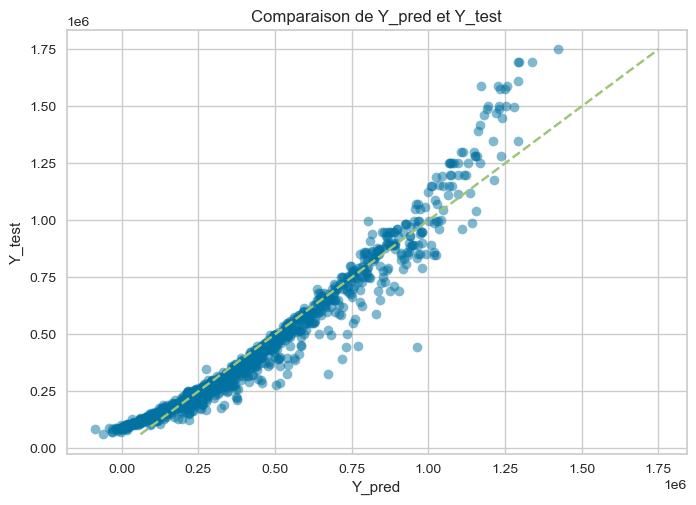

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


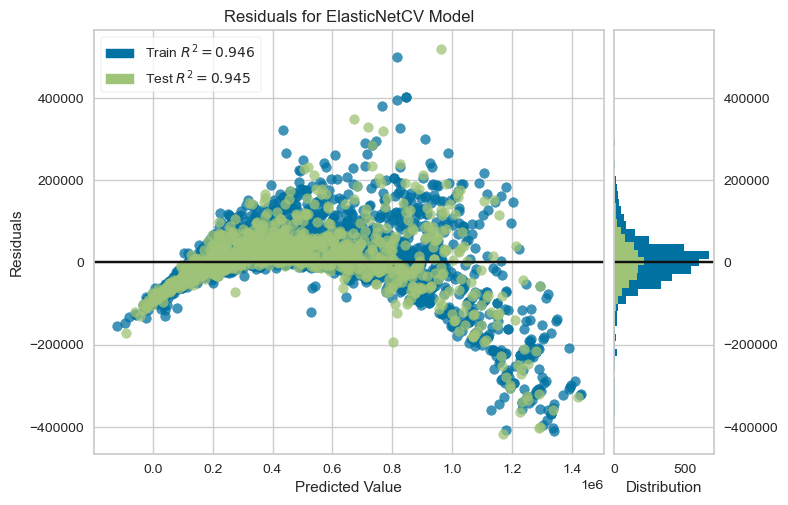

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


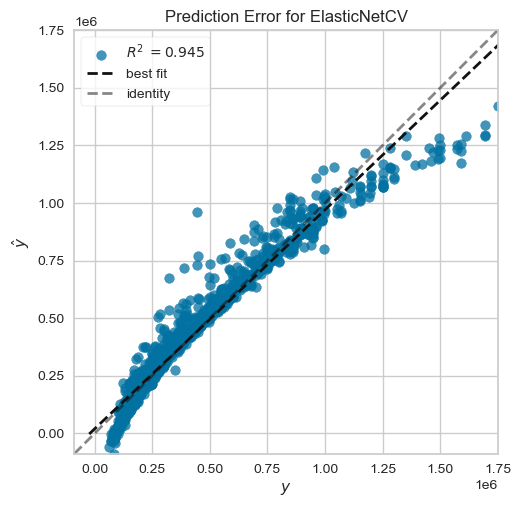

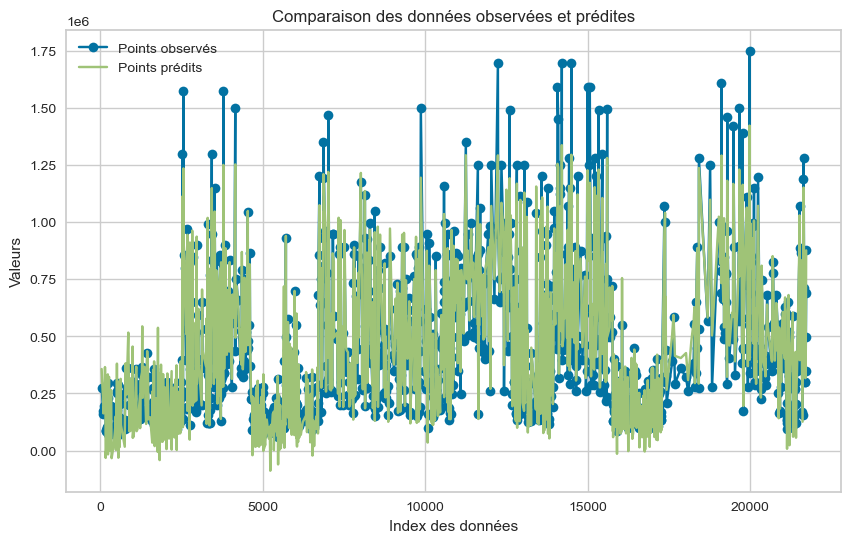

In [43]:
plt.plot(pred_test_s, y_test_s, 'o', alpha=0.5)
min_true = y_test_s.min()
max_true = y_test_s.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend()
plt.show()

# Visualisation des résidus
visualizer = ResidualsPlot(model_en_s)
visualizer.fit(X_train_s, y_train_s)  # Adapter les données d'entraînement au visualiseur
visualizer.score(X_test_s, y_test_s)  # Évaluer le modèle sur les données de test
visualizer.show()                     # Finaliser et afficher la figure

# Visualisation de l'erreur de prédiction
visualizer = PredictionError(model_en_s)
visualizer.fit(X_train_s, y_train_s)
visualizer.score(X_test_s, y_test_s)
visualizer.show()

# Créer un DataFrame avec les points observés et les points prédits
donnees_comparatives_model_s = pd.DataFrame({'points_observés': y_test_s, 'points_predits': pred_test_s})

# Trier les données par index si nécessaire
donnees_comparatives_model_s = donnees_comparatives_model_s.sort_index()

# Tracer les données observées et prédites
plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_s.index, donnees_comparatives_model_s['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_s.index, donnees_comparatives_model_s['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()



Malgré des variables qui ne son pas multicolinéaires, le modèle n'a pas de meilleures performances que le précédent.  
Je vais à présent tester la régression polynomiale.

# Regression polynomiale à 2°

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Sélection des variables explicatives et de la variable cible
Xs = df_annee[vif_data_list]
ys = df_annee['prix_achat']

# Division des données en ensembles d'entraînement, de validation et de test
X_train_2,  X_test_2 , y_train_2,  y_test_2 = train_test_split(Xs, ys, test_size=0.2)
X_train_2 , X_val_2,  y_train_2,  y_val_2= train_test_split(X_train_2 , y_train_2 , test_size=0.2)

# Transformation polynomiale des features
degree = 2  # Degré du polynôme
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_2)
X_val_poly = poly.transform(X_val_2)
X_test_poly = poly.transform(X_test_2)

# Entraînement du modèle ElasticNet avec les données transformées
model_en_2= ElasticNetCV(
    cv=5, 
    l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
    alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
    max_iter=10000
)
model_en_2.fit(X_train_poly, y_train_2)

# Validation croisée
cv_scores = cross_val_score(model_en_2 , X_train_poly, y_train_2 , cv=3, verbose=2)

# Prédiction sur les données d'entraînement, de validation et de test
pred_train_2= model_en_2.predict(X_train_poly)
pred_val_2= model_en_2.predict(X_val_poly)
pred_test_2= model_en_2.predict(X_test_poly)

# Calcul de l'erreur quadratique moyenne
r2_train = model_en_2.score(X_train_poly, y_train_2)
r2_predict = model_en_2.score(X_test_poly, y_test_2)
MAE = mean_absolute_error(y_test_2 , pred_test_2)
MSE = mean_squared_error(y_test_2 , pred_test_2)
RMSE = np.sqrt(mean_squared_error(y_test_2,  pred_test_2))

print('R² train :', r2_train)
print('R² predict:', r2_predict)
print('MAE :', MAE)
print('MSE :', MSE)
print('RMSE :', RMSE)
print('Validation croisée scores :', cv_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   2.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] END .................................................... total time=   1.8s
[CV] END .................................................... total time=   1.6s
R² train : 0.9999922600522728
R² predict: 0.9999989286567168
MAE : 84.7512058606674
MSE : 107042.86166857467
RMSE : 327.17405408830126
Validation croisée scores : [0.99999111 0.99999671 0.99998823]


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s finished


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


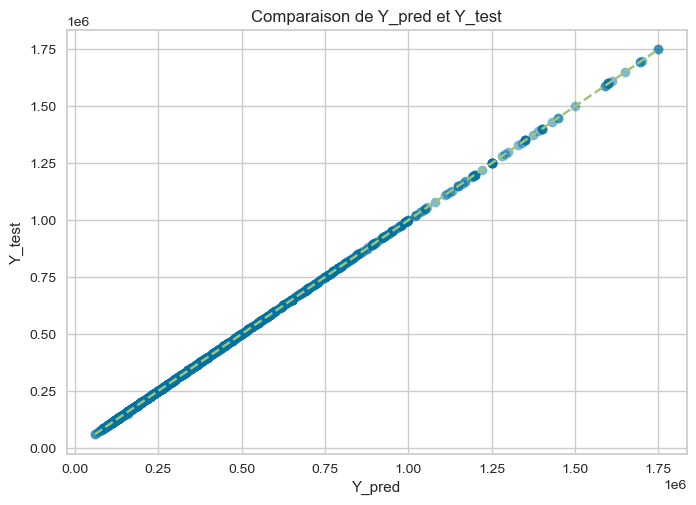

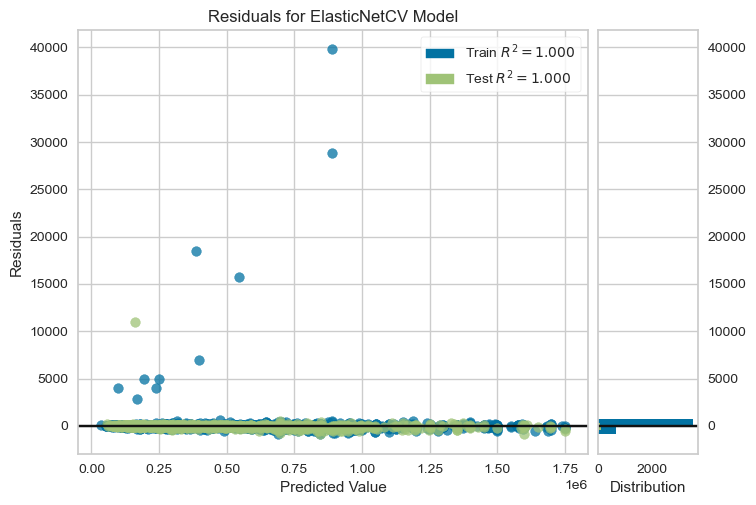

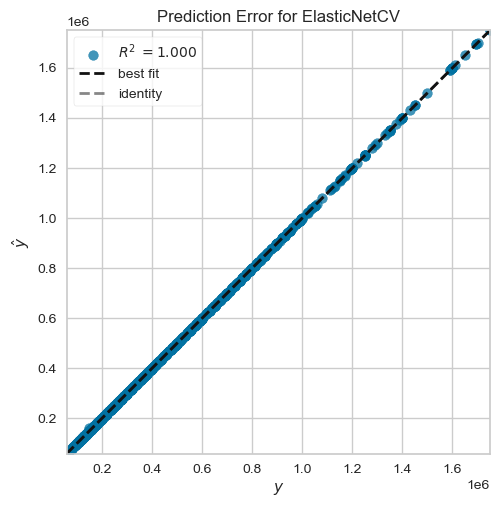

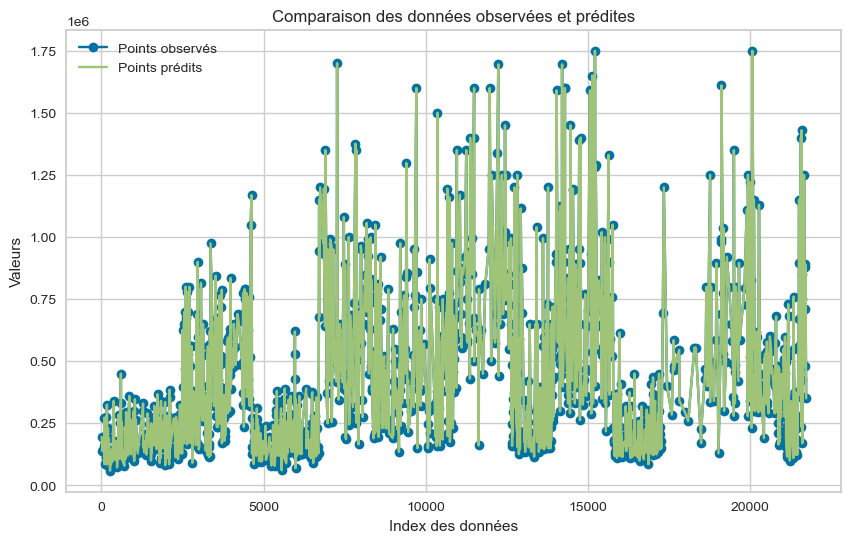

In [45]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.regressor import ResidualsPlot, PredictionError

# Affichage des résultats de la régression polynomiale
plt.plot(pred_test_2, y_test_2, 'o', alpha=0.5)
min_true = y_test_2.min()
max_true = y_test_2.max()
plt.plot([min_true, max_true], [min_true, max_true], '--') 
plt.title('Comparaison de Y_pred et Y_test')
plt.xlabel("Y_pred")
plt.ylabel("Y_test")
plt.legend()
plt.show()

# Visualisation des résidus
visualizer = ResidualsPlot(model_en_2)
visualizer.fit(X_train_poly, y_train_2)  # Adapter les données d'entraînement au visualiseur
visualizer.score(X_test_poly, y_test_2)  # Évaluer le modèle sur les données de test
visualizer.show()                     # Finaliser et afficher la figure

# Visualisation de l'erreur de prédiction
visualizer = PredictionError(model_en_2)
visualizer.fit(X_train_poly, y_train_2)
visualizer.score(X_test_poly, y_test_2)
visualizer.show()


# Créer un DataFrame avec les points observés et les points prédits
donnees_comparatives_model_en_2 = pd.DataFrame({'points_observés': y_test_2, 'points_predits': pred_test_2})

# Trier les données par index si nécessaire
donnees_comparatives_model_en_2 = donnees_comparatives_model_en_2.sort_index()

# Tracer les données observées et prédites
plt.figure(figsize=(10, 6))
plt.plot(donnees_comparatives_model_en_2.index, donnees_comparatives_model_en_2['points_observés'], label='Points observés', marker='o')
plt.plot(donnees_comparatives_model_en_2.index, donnees_comparatives_model_en_2['points_predits'], label='Points prédits', marker='x')
plt.xlabel('Index des données')
plt.ylabel('Valeurs')
plt.title('Comparaison des données observées et prédites')
plt.legend()
plt.grid(True)
plt.show()



Le modèle affiche un score très performant avec un RMSE de 629.

## Evaluation des modèles

Je vais d'abord choisir une ligne de mes données et la soumettre à nos différents modèles.

In [63]:
df_annee.loc[(df_annee['m2_construit']==112),:]

,m2_construit,nb_pieces,nb_sdb,nb_etages,prix_achat,prix_achat_m2,travaux_necessaire,annee_construction,ascenseur,jardin,...,terrace,balcon,salle_rangement,espace_vert,parking,num_quartier,type_appartement,type_duplex,type_maison,type_penthouse
56,112,3,2,0,289000,2580,False,2013.0,True,False,...,False,False,True,True,True,21,True,False,False,False
375,112,3,2,0,230000,2054,False,1965.0,True,False,...,True,False,False,False,False,21,True,False,False,False
762,112,4,2,0,380000,3393,False,1993.0,True,False,...,True,False,False,False,True,21,False,False,False,True
1465,112,3,2,0,320250,2859,False,2007.0,True,False,...,True,False,True,False,False,16,True,False,False,False
2398,112,3,2,0,135000,1205,True,1980.0,True,False,...,True,False,False,False,False,18,True,False,False,False
3542,112,3,2,0,395000,3527,False,1971.0,True,False,...,True,False,False,False,True,17,True,False,False,False
3866,112,3,2,0,372000,3321,False,1960.0,True,False,...,False,False,False,False,False,14,True,False,False,False
3885,112,4,2,0,372000,3321,True,1960.0,True,False,...,False,False,False,False,False,14,True,False,False,False
4332,112,3,2,0,525000,4688,False,1998.0,True,False,...,False,False,True,True,True,14,True,False,False,False
4618,112,2,2,0,395000,3527,False,2006.0,True,False,...,True,False,True,False,True,14,False,False,False,True


In [55]:
# Supposons que vous ayez une nouvelle observation, par exemple 74
nouvelle_observation = np.array([134])  # Convertir en tableau numpy

# Transformer en tableau 2D
nouvelle_observation_2d = nouvelle_observation.reshape(-1, 1)

# Faire une prédiction
prediction = regression.predict(nouvelle_observation_2d)

print("Prédiction:", prediction)


Prédiction: [518882.658294]


In [54]:
X_train.loc[(X_train['annee_construction']==1968),:]

,m2_construit,nb_pieces,nb_sdb,nb_etages,prix_achat_m2,travaux_necessaire,annee_construction,ascenseur,jardin,piscine,terrace,balcon,salle_rangement,espace_vert,parking,num_quartier,type_appartement,type_duplex,type_maison,type_penthouse
12825,134,3,2,0,2149,1,1968.0,1,0,1,0,0,0,1,0,7,1,0,0,0


In [57]:
donnees_entree_2D = np.array(X_train.loc[(X_train['annee_construction']==1968),:]).reshape(1, -1)
model_en.predict(donnees_entree_2D)

/Users/sarah.harouni/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


array([362892.03134958])

In [ ]:
X_train_s

In [59]:
X_train_s.loc[(X_train['annee_construction']==1968),:]

,m2_construit,nb_etages,prix_achat_m2,travaux_necessaire,jardin,piscine,terrace,balcon,salle_rangement,espace_vert,parking,num_quartier,type_duplex,type_maison,type_penthouse
150,121,0,2149,False,False,True,True,True,True,True,True,21,False,False,False


In [ ]:
donnees_entree_s = np.array(X_train_s.loc[(X_train['annee_construction']==1968).reshape(1, -1)
model_en_s.predict(donnees_entree_s)

In [ ]:
X_train_2

In [ ]:
X_train_2.loc[(X_train_2[''],:]

In [ ]:
# Sélectionner une ligne de votre DataFrame
ligne_a_predire = X_train_2.loc[(X_train_2['prix_achat_m2']==2149)&(X_train_2['m2_construit']==74.0),:]

# Extraire les valeurs des caractéristiques
valeurs_caracteristiques = ligne_a_predire.values.reshape(1, -1)

# Appliquer la transformation polynomiale sur cette ligne
ligne_a_predire_transformee = poly.transform(valeurs_caracteristiques)

# Faire une prédiction avec le modèle de régression linéaire
prediction = model_en_2.predict(ligne_a_predire_transformee)

print("Prédiction:", prediction)


In [ ]:
m

In [ ]:
import pickle

# Enregistrer le modèle dans un fichier
filename = 'poly.pkl'
pickle.dump(poly, open(filename, 'wb'))

# Enregistrer le modèle dans un fichier
filename = 'model_en_2.pkl'
pickle.dump(model_en_2, open(filename, 'wb'))



In [ ]:
data.head()

In [ ]:
data.to_csv('data_clean.csv')

In [ ]:
data

In [ ]:
visu = pd.read_csv('visuel.csv',index_col=0)

In [ ]:
visu.tail()

In [ ]:
visu.iloc[-25]